In [1]:
import cv2
import numpy as np
import sys
import pickle   

import os
import logging
import torch
import matplotlib.pyplot as plt

/home/max/development/confluence_webapp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read prediction and investigate

In [32]:
os.getcwd()
os.chdir("../../../")
os.getcwd()

'/home'

In [34]:
os.chdir("max/development/confluence_webapp/")

In [35]:
pred = torch.load("sam_prediction.pt")

In [36]:
input_image = torch.load("sample_img.pt")
with open("sample_img.pkl", "rb") as f:
    numpy_image = pickle.load(f)

In [37]:
show_image = input_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
show_image.shape


(1024, 1024, 3)

In [41]:
pred.min(), pred.max()

(tensor(-1.2495), tensor(-1.2081))

In [38]:
pred_plot = pred.squeeze().detach().cpu().numpy()

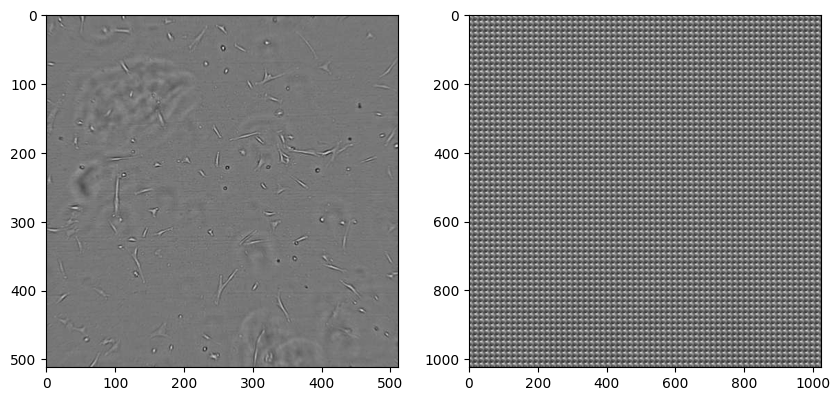

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(numpy_image, cmap='gray')
ax[1].imshow(pred_plot * 255, cmap='gray')


#### Normalize prediction to fit streamlit

In [42]:
# Example normalization to [0.0, 1.0]
pred_plot_normalized = pred_plot - pred_plot.min()  # Shift to start at 0
pred_plot_normalized /= pred_plot_normalized.max()  # Scale to [0, 1]

# Check the new range
print(pred_plot_normalized.min(), pred_plot_normalized.max())  # Should be 0.0, 1.0

# (Optional) Scale to [0, 255] and convert to uint9
pred_plot_uint8 = (pred_plot_normalized * 255).astype(np.uint8)

0.0 1.0


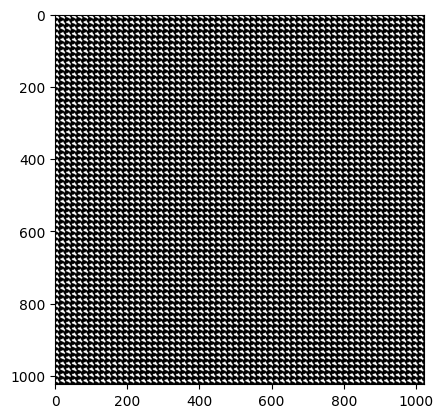

In [43]:
np.unique(pred_plot_normalized > 0.5, return_counts=True)
mask_binary = pred_plot_normalized > 0.5
plt.imshow(mask_binary, cmap='gray')

#### Overlay prediction with masks

In [16]:
def overlay(image, mask, color, alpha, resize=None):
    """Combines image and its segmentation mask into a single image.
    https://www.kaggle.com/code/purplejester/showing-samples-with-segmentation-mask-overlay

    Params:
        image: Training image. np.ndarray,
        mask: Segmentation mask. np.ndarray,
        color: Color for segmentation mask rendering.  tuple[int, int, int] = (255, 0, 0)
        alpha: Segmentation mask's transparency. float = 0.5,
        resize: If provided, both image and its mask are resized before blending them together.
        tuple[int, int] = (1024, 1024))

    Returns:
        image_combined: The combined image. np.ndarray

    """
    color = color[::-1]
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)
    print(colored_mask.shape)
    print(image.shape)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()

    if resize is not None:
        image = cv2.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)

    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)

    return image_combined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1024, 1024)
(1024, 1024, 3)
(1024, 1024, 3)


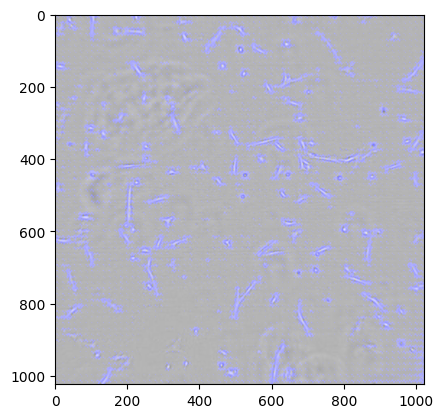

In [17]:
print(mask_binary.shape)
image_combined = overlay(show_image, mask_binary, color=(255, 0, 0), alpha=0.05)
plt.imshow(image_combined)

In [19]:
if not None:
    print("None")

None


## image arrays

In [144]:
with open("image_array_0.pkl", "rb") as f:
    image_array = pickle.load(f)
with open("image_rgb_0.pkl", "rb") as f:
    image_rgb = pickle.load(f)
with open("sample_img.pkl", "rb") as f:
    numpy_image = pickle.load(f)
new_pred = torch.load("sam_prediction.pt")
new_sam_img = torch.load("sample_img.pt")

In [ ]:
print(f"values from image_arra: {np.min(image_array), np.max(image_array)} and shape: {image_array.shape}")
print(f"values from image_rgb: {np.min(image_rgb), np.max(image_rgb)} and shape: {image_rgb.shape}")
print(f"values from numpy_image: {np.min(numpy_image), np.max(numpy_image)} and shape: {numpy_image.shape}")
print(f"values from new_pred: {torch.min(new_pred), torch.max(new_pred)}, shape: {new_pred.shape}")
print(f"values from new_sam_img: {torch.min(new_sam_img), torch.max(new_sam_img)}, shape: {new_sam_img.shape}")
print(f"")

values from image_arra: (122, 250) and shape: (512, 512)
values from image_rgb: (122, 250) and shape: (512, 512, 3)
values from numpy_image: (122, 250) and shape: (512, 512)
values from new_pred: (tensor(-1.0106, grad_fn=<MinBackward1>), tensor(-0.9209, grad_fn=<MaxBackward1>)), shape: torch.Size([1, 1, 1024, 1024])
values from new_sam_img: (tensor(0.5137), tensor(0.9647)), shape: torch.Size([1, 3, 1024, 1024])


### Detectron shape fix


from services.prediction_service import PredictionManager


In [2]:
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from PIL import Image, ImageDraw
def setup_cfg(iter=10):
    """
    Set up the Detectron2 configuration
    Args:
        iter (int): Number of iterations
    Returns:
        cfg (CfgNode): Detectron2 configuration
    """
    
    cfg = get_cfg()
    config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    cfg.merge_from_file(model_zoo.get_config_file(config_name))
    cfg.DATALOADER.NUM_WORKERS = 1
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
    cfg.SOLVER.IMS_PER_BATCH = 1
    if not torch.cuda.is_available():
        cfg.MODEL.DEVICE = "cpu"
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.WARMUP_ITERS = 5
    cfg.SOLVER.MAX_ITER = iter
    cfg.SOLVER.STEPS = []
    # Small value=Frequent save  need a lot of storage.
    cfg.SOLVER.CHECKPOINT_PERIOD = 100000
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
    return cfg
cfg = setup_cfg()

In [6]:
# import DefaultPredictor
from detectron2.engine import DefaultPredictor
dpath = os.path.join("models/lc_models/d2_model_final.pth")
cfg.MODEL.WEIGHTS = dpath
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0
predictor = DefaultPredictor(cfg)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (2, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (2,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (1, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in the mo

In [7]:
def resize_image(image: np.ndarray, min_size: int, max_size: int) -> np.ndarray:
    """
    Resizes an input image while maintaining its aspect ratio, 
    ensuring the shorter edge is at least `min_size` and the 
    longer edge does not exceed `max_size`.

    Args:
        image (np.ndarray): The input image to resize, in the form of a NumPy array.
        min_size (int): The minimum size for the shorter edge of the image.
        max_size (int): The maximum allowed size for the longer edge of the image.

    Returns:
        np.ndarray: The resized image as a NumPy array.
    
    Example:
        resized_image = resize_image(input_image, 800, 1333)
    """
    h, w = image.shape[:2]

    # Scale to the shorter edge
    scale = min_size / min(h, w)
    new_h, new_w = int(h * scale), int(w * scale)

    # Ensure the longer edge does not exceed max_size
    if max(new_h, new_w) > max_size:
        scale = max_size / max(new_h, new_w)
        new_h, new_w = int(new_h * scale), int(new_w * scale)

    resized_image = cv2.resize(image, (new_w, new_h))
    return resized_image

image = Image.open("Aufnahme-06_2Mio_nach_48h.jpg")
img = np.array(image)
min_size = cfg.INPUT.MIN_SIZE_TEST
max_size = cfg.INPUT.MAX_SIZE_TEST

# img = resize_image(image=img, min_size=min_size, max_size=max_size)

# img = np.expand_dims(img, axis=2)

In [8]:
img.shape
pred = predictor(img)

/home/max/development/confluence_webapp/.venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
print(img.shape)

(960, 1280, 3)


In [10]:


def get_total_mask(masks: np.ndarray) -> np.ndarray:
    """
    Combine all individual binary masks into a single mask image.
    
    Args:
        masks (np.ndarray): A 3D numpy array of shape [N, H, W] where N is the number 
                             of masks (instances), and H, W are the height and width 
                             of the image.
    
    Returns:
        np.ndarray: A single 2D binary mask (H, W) where 1 represents a mask and 0 
                    represents the background.
    """
    # Initialize an empty mask with zeros
    total_mask = np.zeros_like(masks[0], dtype=np.uint8)
    
    # Combine all masks using logical OR
    for mask in masks:
        total_mask = np.logical_or(total_mask, mask).astype(np.uint8)
    
    return total_mask


In [11]:
d = {
    "file_name": "Aufnahme-06_2Mio_nach_48h.jpg",
    "height": img.shape[1],
    "width": img.shape[0],
    "file": "M2_Image20.jpg",
}
d

{'file_name': 'Aufnahme-06_2Mio_nach_48h.jpg',
 'height': 1280,
 'width': 960,
 'file': 'M2_Image20.jpg'}

In [12]:
from skimage import measure
def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

def binary_mask_to_polygon(binary_mask, tolerance=0):
    """Converts a binary mask to COCO polygon representation
    Args:
    binary_mask: a 2D binary numpy array where '1's represent the object
    tolerance: Maximum distance from original points of polygon to approximated
    polygonal chain. If tolerance is 0, the original coordinate array is returned.
    """
    polygons = []
    # pad mask to close contours of shapes which start and end at an edge
    padded_binary_mask = np.pad(
        binary_mask, pad_width=1, mode="constant", constant_values=0
    )
    contours = measure.find_contours(padded_binary_mask, 0.5)
    # contours = np.subtract(contours, 1)
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, tolerance)
        if len(contour) < 3:
            continue
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        # after padding and subtracting 1 we may get -0.5 points in our segmentation
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)

    return polygons


def get_confluence(data_dict, pred):
    """calcuclates impedance from detectron predictions

    ARGS:
        data_dict - (dict): metadata about image and annotations
        pred - (dict): data of detectron2 predictionsa
    RETURNS:
        confluence - (float): percentage of cells on image

    """

    masks = pred["instances"].pred_masks
    file_name = data_dict["file_name"]
    if not type(file_name) == str:
        file_name = file_name.name  # when file comes from webapp
    annotations = []
    pixel_sum = 0
    for i in range(len(pred["instances"])):
        mask_array = masks[i, :, :].detach().cpu().clone().numpy()
        pixel_sum += mask_array.sum()
        try:
            segmentation = binary_mask_to_polygon(mask_array)
            annotations.append(segmentation)
        except Exception as e:
            print(f"Error: {e}")

    confluence = pixel_sum / (data_dict["height"] * data_dict["width"])
    return confluence, annotations



In [23]:
conf, ann = get_confluence(d, pred)

In [104]:
def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour


def binary_mask_to_polygon(binary_mask, tolerance=0):
    """Converts a binary mask to COCO polygon representation
    Args:
    binary_mask: a 2D binary numpy array where '1's represent the object
    tolerance: Maximum distance from original points of polygon to approximated
    polygonal chain. If tolerance is 0, the original coordinate array is returned.
    """
    polygons = []
    # pad mask to close contours of shapes which start and end at an edge
    padded_binary_mask = np.pad(
        binary_mask, pad_width=1, mode="constant", constant_values=0
    )
    contours = measure.find_contours(padded_binary_mask, 0.5)
    # contours = np.subtract(contours, 1)
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, tolerance)
        if len(contour) < 3:
            continue
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        # after padding and subtracting 1 we may get -0.5 points in our segmentation
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)

    return polygons


def get_confluence(data_dict, pred):
    """calcuclates impedance from detectron predictions

    ARGS:
        data_dict - (dict): metadata about image and annotations
        pred - (dict): data of detectron2 predictionsa
    RETURNS:
        confluence - (float): percentage of cells on image

    """
    logger = logging.getLogger(__name__)

    masks = pred["instances"].pred_masks
    file_name = data_dict["file_name"]
    if not type(file_name) == str:
        file_name = file_name.name  # when file comes from webapp
    annotations = []
    pixel_sum = 0
    for i in range(len(pred["instances"])):
        mask_array = masks[i, :, :].detach().cpu().clone().numpy()
        pixel_sum += mask_array.sum()
        try:
            segmentation = binary_mask_to_polygon(mask_array)
            annotations.append(segmentation)
        except Exception as e:
            logger.warning(e)
            logger.warning(
                f"Could not create polygon from prediction {i} from image {file_name}"
            )
            logger.warning(f"Shape: {np.unique(mask_array)}")

    confluence = pixel_sum / (data_dict["height"] * data_dict["width"])
    return confluence, annotations


def visualize_result2(data_dict, anns, output_dir="output"):
    import logging
    logger = logging.getLogger(__name__)

    # img_out = Image.new("L", [data_dict["height"], data_dict["width"], ])
    img_out = Image.new("L", [data_dict["width"], data_dict["height"], ])
    print(f'img_out size: {img_out.size}')
    print(f' with form data: {data_dict["width"]} and {data_dict["height"]} ')

    file_name = data_dict["file_name"]
    logger.info(file_name)
    org_image = Image.open(file_name).convert("RGBA")

    img_out1 = ImageDraw.Draw(img_out)
    overlay_out = ImageDraw.Draw(org_image, "RGBA")
    print('with overlay')
    for i in range(len(anns)):
        if len(anns[i]) <5:
            continue
        try:
            segs = anns[i][0]
            img_out1.polygon(segs, fill="white", outline="white")
            overlay_out.polygon(segs, fill=(
                21, 239, 116, 27), outline="#B7FF00")
        except Exception as e:
            logger.warning(e)
            logger.warning(
                f" Could not create mask for {i} for file: {file_name}")

    if not os.path.exists(os.path.join(output_dir, "masks")):
        logger.info("create output dir: ./masks")
        os.mkdir(os.path.join(output_dir, "masks"))
    if not os.path.exists(os.path.join(output_dir, "masks", "overlay")):
        os.mkdir(os.path.join(output_dir, "masks", "overlay"))

    # for case that file comes from webapp
    if not type(file_name) is str:
        file_name = file_name.name
    outfile = os.path.join(output_dir, "masks", os.path.basename(
        file_name).split(".")[0] + "_mask" + ".png")
    overlay_file = os.path.join(
        output_dir, "masks", "overlay", os.path.basename(file_name).split(".")[
            0] + "_overlay" + ".png"
    )
    org_image.save(overlay_file)
    img_out.save(outfile)
    return org_image



In [13]:
mask = pred["instances"].pred_masks[0]

In [14]:
mask

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

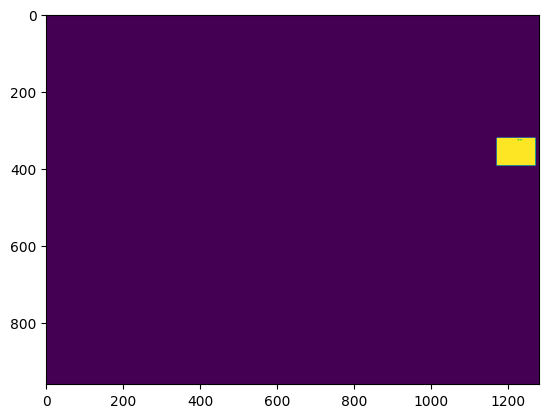

In [15]:
plot_mask = mask.detach().cpu().clone().numpy()
plt.imshow(plot_mask)

In [17]:
np.unique(plot_mask, return_counts=True)

(array([False,  True]), array([1221538,    7262]))

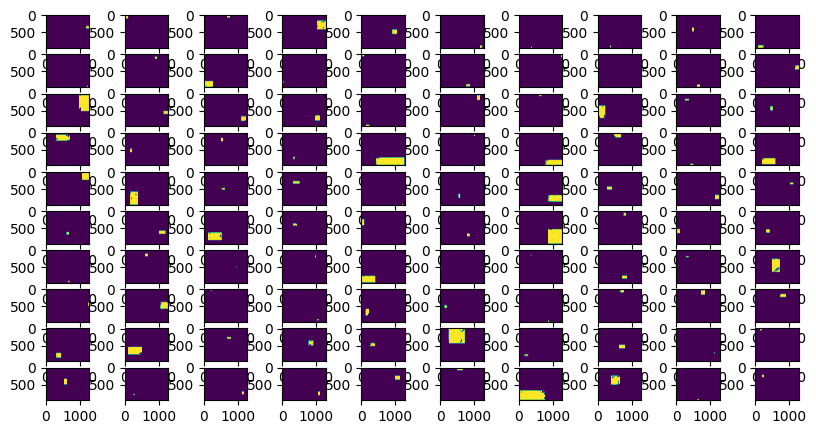

In [18]:
fig, ax = plt.subplots(10, 10, figsize=(10, 5))
for mask, a in zip(pred["instances"].pred_masks, ax.flatten()):
    plot_mask = mask.detach().cpu().clone().numpy()
    a.imshow(plot_mask)

In [ ]:

Apred.keys()

dict_keys(['instances'])

In [21]:
pred["instances"]

Instances(num_instances=100, image_height=960, image_width=1280, fields=[pred_boxes: Boxes(tensor([[1.1682e+03, 3.2002e+02, 1.2727e+03, 3.9393e+02],
        [1.2345e+01, 1.3432e+01, 9.9813e+01, 1.0775e+02],
        [6.7501e+02, 3.0302e-01, 7.6851e+02, 7.8078e+01],
        [1.0123e+03, 1.5468e+02, 1.2800e+03, 4.2063e+02],
        [9.1159e+02, 4.1725e+02, 1.0446e+03, 5.5194e+02],
        [1.1642e+03, 8.8078e+02, 1.2341e+03, 9.5670e+02],
        [3.4641e+02, 9.2138e+02, 3.8107e+02, 9.5526e+02],
        [3.4649e+02, 8.8912e+02, 3.7785e+02, 9.4544e+02],
        [4.6594e+02, 3.5955e+02, 5.2934e+02, 4.7939e+02],
        [8.9834e+01, 8.7588e+02, 2.6713e+02, 9.5615e+02],
        [1.1832e+03, 9.1579e+02, 1.2264e+03, 9.5754e+02],
        [8.6053e+02, 6.7086e+01, 9.3180e+02, 1.4298e+02],
        [3.2894e+01, 7.8114e+02, 2.7426e+02, 9.5967e+02],
        [2.1128e+01, 7.9404e+02, 6.2088e+01, 8.3039e+02],
        [2.1398e+01, 1.8666e-01, 1.0197e+02, 6.6071e+01],
        [7.5027e+02, 8.7232e+02, 8.8579

In [25]:
len(ann)

100

In [26]:
len(ann[0])

3

In [27]:
ann[0][0]

[1271.0,
 393.5,
 1270.0,
 393.5,
 1269.0,
 393.5,
 1268.0,
 393.5,
 1267.0,
 393.5,
 1266.0,
 393.5,
 1265.0,
 393.5,
 1264.0,
 393.5,
 1263.0,
 393.5,
 1262.0,
 393.5,
 1261.0,
 393.5,
 1260.0,
 393.5,
 1259.0,
 393.5,
 1258.0,
 393.5,
 1257.0,
 393.5,
 1256.0,
 393.5,
 1255.0,
 393.5,
 1254.0,
 393.5,
 1253.0,
 393.5,
 1252.0,
 393.5,
 1251.0,
 393.5,
 1250.0,
 393.5,
 1249.0,
 393.5,
 1248.0,
 393.5,
 1247.0,
 393.5,
 1246.0,
 393.5,
 1245.0,
 393.5,
 1244.0,
 393.5,
 1243.0,
 393.5,
 1242.0,
 393.5,
 1241.0,
 393.5,
 1240.0,
 393.5,
 1239.0,
 393.5,
 1238.0,
 393.5,
 1237.0,
 393.5,
 1236.0,
 393.5,
 1235.0,
 393.5,
 1234.0,
 393.5,
 1233.0,
 393.5,
 1232.0,
 393.5,
 1231.0,
 393.5,
 1230.0,
 393.5,
 1229.0,
 393.5,
 1228.0,
 393.5,
 1227.0,
 393.5,
 1226.0,
 393.5,
 1225.0,
 393.5,
 1224.0,
 393.5,
 1223.0,
 393.5,
 1222.0,
 393.5,
 1221.0,
 393.5,
 1220.0,
 393.5,
 1219.0,
 393.5,
 1218.0,
 393.5,
 1217.0,
 393.5,
 1216.0,
 393.5,
 1215.0,
 393.5,
 1214.0,
 393.5,
 1213.0,
 393.

In [28]:
ann[0][1]

[1229.5,
 327.0,
 1229.0,
 326.5,
 1228.0,
 326.5,
 1227.0,
 326.5,
 1226.0,
 326.5,
 1225.0,
 326.5,
 1224.5,
 327.0,
 1225.0,
 327.5,
 1226.0,
 327.5,
 1227.0,
 327.5,
 1228.0,
 327.5,
 1229.0,
 327.5,
 1229.5,
 327.0]

In [29]:
ann[0][4]

IndexError: list index out of range

In [30]:
for an in ann:
    print(len(an))

3
7
1
12
1
3
1
1
2
11
3
14
9
1
6
13
1
1
5
15
6
1
4
12
11
6
16
13
1
2
13
5
1
4
3
9
6
19
8
6
6
19
3
1
4
1
11
1
6
1
1
1
14
10
4
5
8
7
4
9
1
7
1
10
13
1
1
3
1
16
12
10
1
1
8
9
4
19
5
5
1
5
1
6
15
12
17
1
4
1
1
6
1
4
1
10
8
10
4
3


In [5]:
os.getcwd()
os.chdir("../..")

In [9]:

os.getcwd()

'/home/max/development/confluence_webapp/confluence_webapp'

In [17]:

from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
def setup_cfg(iter=10):
    """
    Set up the Detectron2 configuration
    Args:
        iter (int): Number of iterations
    Returns:
        cfg (CfgNode): Detectron2 configuration
    """

    cfg = get_cfg()
    config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    cfg.merge_from_file(model_zoo.get_config_file(config_name))
    cfg.DATALOADER.NUM_WORKERS = 1
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
    cfg.SOLVER.IMS_PER_BATCH = 1
    if not torch.cuda.is_available():
        cfg.MODEL.DEVICE = "cpu"
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.WARMUP_ITERS = 5
    cfg.SOLVER.MAX_ITER = iter
    cfg.SOLVER.STEPS = []
    # Small value=Frequent save  need a lot of storage.
    cfg.SOLVER.CHECKPOINT_PERIOD = 100000
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

    return cfg


def register_datasets(data_dict, dataset_dir, annot_file="annotations.json"):
    """lets detectron know about customd datasets
    Params:
        data_dict: dictionary of dataset names and paths
        dataset_dir: directory where datasets are stored
        annot_file: name of annotation file
    Returns:
        dataset_dicts: dictionary of dataset names and paths
        metadata_dicts: dictionary of dataset names and metadata

    """
    if train_name in DatasetCatalog.list():
        DatasetCatalog.remove(train_name)
    if valid_name in DatasetCatalog.list():
        DatasetCatalog.remove(valid_name)
    if test_name in DatasetCatalog.list():
        DatasetCatalog.remove(test_name)
    if pool_name in DatasetCatalog.list():
        DatasetCatalog.remove(pool_name)
    for k, v in data_dict.items():
        register_coco_instances(
            k,
            {},
            os.path.join(dataset_dir, v, annot_file),
            os.path.join(dataset_dir, v),
        )

    dataset_dicts = DatasetCatalog.get(train_name)
    metadata_dicts = MetadataCatalog.get(train_name)
    return dataset_dicts, metadata_dicts




basename = "04cur_data"
output_dir = "metadicts"


global train_name
global valid_name
global test_name
global pool_name
global cfg
train_name = basename + "_" + "train"
test_name = basename + "_" + "test"
valid_name = basename + "_" + "valid"
pool_name = basename + "_" + "pool"
data_dict = {
    train_name: "train",
    valid_name: "valid",
    test_name: "test",
    pool_name: "pool",
}

# LOGGING -----------------------------------------------------------------

logger = logging.getLogger(__name__)
log_fmt = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
# log stream handler to log to stdout
handler = logging.StreamHandler(sys.stdout)
logging.basicConfig(level=logging.INFO, format=log_fmt, handlers=[handler])


# CONFIG ------------------------------------------------------------------
logger.info("start building config")
cfg = setup_cfg(output_dir)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

dataset_dicts, metadata_dicts = register_datasets(data_dict, basename)

cfg.DATASETS.TRAIN = (train_name,)
cfg.DATASETS.TEST = (test_name,)
with open("datasetdicts.pkl", "wb") as f:
    pickle.dump((dataset_dicts, metadata_dicts), f)

# logger.info("visualizing input data")
# visualize_data(dataset_dicts, metadata_dicts, output_dir=cfg.OUTPUT_DIR)





2024-11-29 08:04:54,414 - __main__ - INFO - start building config


FileNotFoundError: [Errno 2] No such file or directory: '04cur_data/train/annotations.json'

In [18]:
os.getcwd()

'/home/max/development/confluence_webapp/confluence_webapp'

In [16]:
with open("datasetdicts_d2.pkl", "rb") as f:
    dataset_dicts, metadata_dicts = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'datasetdicts_d2.pkl'

In [12]:
os.getcwd()

'/home/max/development/confluence_webapp/confluence_webapp'

In [13]:
os.listdir()

['output', 'src']